3.16.2 获取和读取数据集
比赛数据分为训练数据集和测试数据集。两个数据集都包括每栋房子的特征，如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚至是缺失值“na”。只有训练数据集包括了每栋房子的价格，也就是标签。我们可以访问比赛网页，点击图3.8中的“Data”标签，并下载这些数据集。

我们将通过pandas库读入并处理数据。在导入本节需要的包前请确保已安装pandas库，否则请参考下面的代码注释。

In [22]:
# 如果没有安装pandas，则反注释下面一行
# !pip install pandas

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import initializers as init
print(tf.__version__)

2.0.0


假设解压后的数据位于./data/kaggle_house/目录，它包括两个csv文件。下面使用pandas读取这两个文件

In [2]:
train_data = pd.read_csv('../data/kaggle_house/train.csv')
test_data = pd.read_csv('../data/kaggle_house/test.csv')

训练数据集包括1460个样本、80个特征和1个标签。

In [3]:
train_data.shape # 输出 (1460, 81)

(1460, 81)

测试数据集包括1459个样本和80个特征。我们需要将测试数据集中每个样本的标签预测出来。

In [4]:
test_data.shape # 输出 (1459, 80)

(1459, 80)

让我们来查看前4个样本的前4个特征、后2个特征和标签（SalePrice）：

In [5]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


可以看到第一个特征是Id，它能帮助模型记住每个训练样本，但难以推广到测试样本，所以我们不使用它来训练。我们将所有的训练数据和测试数据的79个特征按样本连结。train_data.iloc[:, 1:-1]列出从第一列到最后一列所有的样本，concat将样本按列连接。

In [6]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

3.16.3. 预处理数据¶
我们对连续数值的特征做标准化（standardization）：设该特征在整个数据集上的均值为μ，标准差为σ。那么，我们可以将该特征的每个值先减去μ再除以σ得到标准化后的每个特征值。对于缺失的特征值，我们将其替换成该特征的均值。!

In [7]:
#numeric_features表示所有值为连续值得下标
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个特征的均值变为0，所以可以直接用0来替换缺失值，fillna（0）可以对缺失值进行填充
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来将离散数值转成指示特征。举个例子，假设特征MSZoning里面有两个不同的离散值RL和RM，那么这一步转换将去掉MSZoning特征，并新加两个特征MSZoning_RL和MSZoning_RM，其值为0或1。如果一个样本原来在MSZoning里的值为RL，那么有MSZoning_RL=1且MSZoning_RM=0。

In [8]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)

可以看到这一步转换将特征数从79增加到了331。
最后，通过values属性得到NumPy格式的数据，并转成NDArray方便后面的训练

In [9]:
n_train = train_data.shape[0]
train_features = np.array(all_features[:n_train].values,dtype=float)
test_features = np.array(all_features[n_train:].values,dtype=float)
train_labels = np.array(train_data.SalePrice.values.reshape(-1, 1),dtype=float)

3.16.4. 训练模型¶
我们使用一个基本的线性回归模型和平方损失函数来训练模型,因为tensorflow中的keras中有对数均方根误差，故我们直接就使用。

In [93]:
loss_f=tf.keras.losses.mse
def get_net():
    net = keras.models.Sequential()
    net.add(keras.layers.Dense(1))
    return net

对数均方根误差的实现如下，因为已经keras中已经集成了对数均方根误差，故直接调用

In [84]:
log_rmse=tf.keras.losses.mean_squared_logarithmic_error

3.16.5.  K 折交叉验证¶
我们在“模型选择、欠拟合和过拟合”一节中介绍了 K 折交叉验证。它将被用来选择模型设计并调节超参数。下面实现了一个函数，它返回第i折交叉验证时所需要的训练和验证数据。

In [85]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], axis=0)
            y_train = tf.concat([y_train, y_part], axis=0)
    return X_train, y_train, X_valid, y_valid

在 K 折交叉验证中我们训练 K 次并返回训练和验证的平均误差。

In [103]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
  # create model
        data = get_k_fold_data(k, i, X_train, y_train)
        net=get_net()
    # Compile model
        net.compile(loss=tf.keras.losses.mean_squared_logarithmic_error, optimizer=tf.keras.optimizers.Adam(learning_rate))
    # Fit the model
        history=net.fit(data[0], data[1],validation_data=(data[2], data[3]), epochs=num_epochs, batch_size=batch_size,validation_freq=1,verbose=0)
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        print('fold %d, train rmse %f, valid rmse %f'
              % (i, loss[-1], val_loss[-1]))
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='train')
    plt.plot(val_loss, label='valid')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

3.16.6. 模型选择¶
我们使用一组未经调优的超参数并计算交叉验证误差。可以改动这些超参数来尽可能减小平均测试误差

fold 0, train rmse 11.366129, valid rmse 11.477915
fold 1, train rmse 11.860233, valid rmse 11.891942
fold 2, train rmse 4.521535, valid rmse 4.599776
fold 3, train rmse 5.571686, valid rmse 5.324833
fold 4, train rmse 11.138485, valid rmse 11.130119


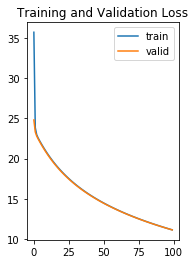

In [104]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)

3.16.7. 预测并在Kaggle提交结果¶
下面定义预测函数。在预测之前，我们会使用完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式。

In [73]:
x_train=tf.convert_to_tensor(train_features,dtype=tf.float32)
y_train=tf.convert_to_tensor(train_labels,dtype=tf.float32)
x_test=tf.convert_to_tensor(test_features,dtype=tf.float32)
model=tf.keras.models.Sequential([
  tf.keras.layers.Dense(1)
])
adam=tf.keras.optimizers.Adam(0.5)
model.compile(optimizer=adam,
              loss=tf.keras.losses.mean_squared_logarithmic_error
              )
model.fit(x_train, y_train, epochs=200,batch_size=32,verbose=0)
preds=np.array(model.predict(x_test))
test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
submission.to_csv('submission.csv', index=False)